Covid-19 in India <br>
Dataset on Novel Corona Virus Disease 2019 in India <br>
Author: Sudalairaj Kumar <br>
Data acquired from Kaggle: <br>
https://www.kaggle.com/sudalairajkumar/covid19-in-india?select=covid_19_india.csv <br>
<br>
Files acquired:
- covid_19_india.csv
- covid_vaccine_statewise.csv
- StatewiseTestingDetails.csv

# Planning <br>
### Combine covid_19_india.csv and covid_vaccine_statewise.csv into a single dataframe
### Features to be used from covid_19_india.csv:
- State
- Date
- Cured
- Deaths
<br>
### Features to be used from covid_vaccine_statewise.csv: <br>
- State
- Updated on
- Total Doses Administered
- AEFI

### Clean 'State' columns in each file so that they are equivalent
### Drop 'Sno' because it can't be combined with other tables, we are going for state-wide view instead of individual patient view
### Join dataframes on 'date' and 'state' columns (after cleaning)
### Drop unwanted columns (or those with too many nulls)
### Perform other data preparation
### First look at data as time-series, then as multi-factorial


# Acquire

In [68]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")



# Sets precision of 2 and suppresses scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Seperates thousands, millions, etc with commas
pd.options.display.float_format = '{:,}'.format



In [2]:
df = pd.read_csv('covid_19_india.csv')
df.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,2020-01-30,6:00 PM,Kerala,1,0,0,0,1
1,2,2020-01-31,6:00 PM,Kerala,1,0,0,0,1
2,3,2020-02-01,6:00 PM,Kerala,2,0,0,0,2
3,4,2020-02-02,6:00 PM,Kerala,3,0,0,0,3
4,5,2020-02-03,6:00 PM,Kerala,3,0,0,0,3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18110 entries, 0 to 18109
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Sno                       18110 non-null  int64 
 1   Date                      18110 non-null  object
 2   Time                      18110 non-null  object
 3   State/UnionTerritory      18110 non-null  object
 4   ConfirmedIndianNational   18110 non-null  object
 5   ConfirmedForeignNational  18110 non-null  object
 6   Cured                     18110 non-null  int64 
 7   Deaths                    18110 non-null  int64 
 8   Confirmed                 18110 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.2+ MB


In [4]:
state_from_df = pd.Series(np.unique(df['State/UnionTerritory']))
state_from_df

0                  Andaman and Nicobar Islands
1                               Andhra Pradesh
2                            Arunachal Pradesh
3                                        Assam
4                                        Bihar
5                                    Bihar****
6             Cases being reassigned to states
7                                   Chandigarh
8                                 Chhattisgarh
9                       Dadra and Nagar Haveli
10    Dadra and Nagar Haveli and Daman and Diu
11                                 Daman & Diu
12                                       Delhi
13                                         Goa
14                                     Gujarat
15                                     Haryana
16                            Himachal Pradesh
17                           Himanchal Pradesh
18                           Jammu and Kashmir
19                                   Jharkhand
20                                  Karanataka
21           

In [5]:
state_from_df.shape

(46,)

In [6]:
vaccine_df = pd.read_csv('covid_vaccine_statewise.csv')
vaccine_df.head()

,Updated On,State,Total Doses Administered,Sessions,Sites,First Dose Administered,Second Dose Administered,Male (Doses Administered),Female (Doses Administered),Transgender (Doses Administered),...,18-44 Years (Doses Administered),45-60 Years (Doses Administered),60+ Years (Doses Administered),18-44 Years(Individuals Vaccinated),45-60 Years(Individuals Vaccinated),60+ Years(Individuals Vaccinated),Male(Individuals Vaccinated),Female(Individuals Vaccinated),Transgender(Individuals Vaccinated),Total Individuals Vaccinated
0,16/01/2021,India,"48,276.0","3,455.0","2,957.0","48,276.0",0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"23,757.0","24,517.0",2.0,"48,276.0"
1,17/01/2021,India,"58,604.0","8,532.0","4,954.0","58,604.0",0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"27,348.0","31,252.0",4.0,"58,604.0"
2,18/01/2021,India,"99,449.0","13,611.0","6,583.0","99,449.0",0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"41,361.0","58,083.0",5.0,"99,449.0"
3,19/01/2021,India,"195,525.0","17,855.0","7,951.0","195,525.0",0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"81,901.0","113,613.0",11.0,"195,525.0"
4,20/01/2021,India,"251,280.0","25,472.0","10,504.0","251,280.0",0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"98,111.0","153,145.0",24.0,"251,280.0"


In [7]:
vaccine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7845 entries, 0 to 7844
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Updated On                           7845 non-null   object 
 1   State                                7845 non-null   object 
 2   Total Doses Administered             7621 non-null   float64
 3   Sessions                             7621 non-null   float64
 4    Sites                               7621 non-null   float64
 5   First Dose Administered              7621 non-null   float64
 6   Second Dose Administered             7621 non-null   float64
 7   Male (Doses Administered)            7461 non-null   float64
 8   Female (Doses Administered)          7461 non-null   float64
 9   Transgender (Doses Administered)     7461 non-null   float64
 10   Covaxin (Doses Administered)        7621 non-null   float64
 11  CoviShield (Doses Administered

In [8]:
state_from_vaccine = pd.Series(np.unique(vaccine_df.State))
state_from_vaccine

0                  Andaman and Nicobar Islands
1                               Andhra Pradesh
2                            Arunachal Pradesh
3                                        Assam
4                                        Bihar
5                                   Chandigarh
6                                 Chhattisgarh
7     Dadra and Nagar Haveli and Daman and Diu
8                                        Delhi
9                                          Goa
10                                     Gujarat
11                                     Haryana
12                            Himachal Pradesh
13                                       India
14                           Jammu and Kashmir
15                                   Jharkhand
16                                   Karnataka
17                                      Kerala
18                                      Ladakh
19                                 Lakshadweep
20                              Madhya Pradesh
21           

In [9]:
# The number of states between the files is different
state_from_vaccine.shape

(37,)

In [10]:
testing_df = pd.read_csv('StatewiseTestingDetails.csv')
testing_df.head()

,Date,State,TotalSamples,Negative,Positive
0,2020-04-17,Andaman and Nicobar Islands,"1,403.0",1210,12.0
1,2020-04-24,Andaman and Nicobar Islands,"2,679.0",NaN,27.0
2,2020-04-27,Andaman and Nicobar Islands,"2,848.0",NaN,33.0
3,2020-05-01,Andaman and Nicobar Islands,"3,754.0",NaN,33.0
4,2020-05-16,Andaman and Nicobar Islands,"6,677.0",NaN,33.0


In [11]:
testing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16336 entries, 0 to 16335
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          16336 non-null  object 
 1   State         16336 non-null  object 
 2   TotalSamples  16336 non-null  float64
 3   Negative      6969 non-null   object 
 4   Positive      5662 non-null   float64
dtypes: float64(2), object(3)
memory usage: 638.2+ KB


### Takeaways from Acquire: <br>
- covid_19_india.csv has no nulls, the other two files have some columns with no or few nulls and some columns with many nulls
- covid_19_india.csv has a unique serial number for each case, the other files do not
- covid_19_india.csv has state, date, cured, deaths, and confirmed cases (no nulls in these features)
- Date is date of observation, but does not say which observation; I will assume they mean the last observation
- covid_vaccine_statewise.csv has state and general vaccine info with few nulls
- Nothing like a patient_id tying covid outcome to vaccination status
- Overall covid outcome can be tied to overall vaccination status by State
- StatewiseTestingDetails.csv has many nulls in the features that would be most usefull
- Comparison of State between files will require data cleaning
- Some column names are not coding-safe

# Prepare

In [12]:
def prepare_data(df, vaccine_df):
    # Correct issues with state names
    # Asterixes were removed from names
    # Some states had several spellings, and were combined into one form
    # Some states were not state names and were changed to null
    df = df.replace('Bihar****', 'Bihar')
    df = df.replace('Cases being reassigned to states', 'Other')
    df = df.replace('Dadra and Nagar Haveli', 'Dadra and Nagar Haveli and Daman and Diu')
    df = df.replace('Daman & Diu', 'Dadra and Nagar Haveli and Daman and Diu')
    df = df.replace('Himanchal Pradesh', 'Himachal Pradesh')
    df = df.replace('Karanataka', 'Karnataka')
    df = df.replace('Madhya Pradesh***', 'Madhya Pradesh')
    df = df.replace('Maharashtra***', 'Maharashtra')
    df = df.replace('Telengana', 'Telangana')
    df = df.replace('Unassigned', 'Other')
    vaccine_df = vaccine_df.replace('India', 'Other')
    
    # Change column names for ease-of-use
    df = df.rename(columns={'Date':'date', 
                            'State/UnionTerritory':'state',
                            'Cured':'cured', 
                            'Deaths':'deaths'})
    
    vaccine_df = vaccine_df.rename(columns={'Updated On':'date', 
                                            'State':'state', 
                                            'Total Doses Administered':'total_doses'}) 
    
    # Drop unwanted columns
    df = df.drop(columns=['Sno', 'Time', 'ConfirmedIndianNational', 
                          'ConfirmedForeignNational', 'Confirmed'])
    
    vaccine_df = vaccine_df.drop(columns=['18-44 Years (Doses Administered)', 
                                          '45-60 Years (Doses Administered)', 
                                          '60+ Years (Doses Administered)',
                                          '18-44 Years(Individuals Vaccinated)',
                                          '45-60 Years(Individuals Vaccinated)',
                                          '60+ Years(Individuals Vaccinated)', 
                                          'Male(Individuals Vaccinated)', 
                                          'Female(Individuals Vaccinated)', 
                                          'Transgender(Individuals Vaccinated)', 
                                          'Total Individuals Vaccinated', 
                                          'First Dose Administered', 
                                          'Second Dose Administered', 
                                          'Male (Doses Administered)', 
                                          'Female (Doses Administered)', 
                                          'Transgender (Doses Administered)', 
                                          ' Covaxin (Doses Administered)', 
                                          'CoviShield (Doses Administered)', 
                                          'Sputnik V (Doses Administered)', 
                                          ' Sites ', 
                                          'Sessions'])

    # Drop nulls from vaccine dataframe, date and state had no nulls
    # Assume that other nulls occured because healthcare workers do not
    # always fill out a list of things that they don't give a patient.
    # Thus, the real value is probably 0
    # The other dataframe has no nulls
    vaccine_df = vaccine_df.fillna(0)
    
    # Convert 'date' to datetime type for both dataframes
    df.date = pd.to_datetime(df.date)
    vaccine_df.date = pd.to_datetime(vaccine_df.date)
    # Set date as index for both dataframes
    df = df.set_index('date').sort_index()
    vaccine_df = vaccine_df.set_index('date').sort_index()
      
    return df, vaccine_df

df, vaccine_df = prepare_data(df, vaccine_df)

In [13]:
state_from_df = pd.Series(np.unique(df['state']))
state_from_df.shape

(37,)

In [14]:
# Both dataframes have an equal number of states
state_from_vaccine = pd.Series(np.unique(vaccine_df.state))
state_from_vaccine.shape

(37,)

In [15]:
# Columns of states appear the same
states = pd.DataFrame(pd.concat([state_from_df, state_from_vaccine], axis=1))
states

,0,1
0,Andaman and Nicobar Islands,Andaman and Nicobar Islands
1,Andhra Pradesh,Andhra Pradesh
2,Arunachal Pradesh,Arunachal Pradesh
3,Assam,Assam
4,Bihar,Bihar
5,Chandigarh,Chandigarh
6,Chhattisgarh,Chhattisgarh
7,Dadra and Nagar Haveli and Daman and Diu,Dadra and Nagar Haveli and Daman and Diu
8,Delhi,Delhi
9,Goa,Goa


In [16]:
# States from both columns are equal
state_from_df == state_from_vaccine

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
27    True
28    True
29    True
30    True
31    True
32    True
33    True
34    True
35    True
36    True
dtype: bool

In [17]:
df.head()

,state,cured,deaths
date,,,
2020-01-30,Kerala,0,0
2020-01-31,Kerala,0,0
2020-02-01,Kerala,0,0
2020-02-02,Kerala,0,0
2020-02-03,Kerala,0,0


In [18]:
vaccine_df.head()

,state,total_doses,AEFI
date,,,
2021-01-02,Jammu and Kashmir,"21,322.0",0.0
2021-01-02,Haryana,"96,304.0",0.0
2021-01-02,Kerala,"173,482.0",0.0
2021-01-02,Gujarat,"284,170.0",0.0
2021-01-02,Rajasthan,"313,321.0",0.0


In [19]:
df.state.value_counts()

Kerala                                      560
Delhi                                       528
Telangana                                   528
Rajasthan                                   527
Haryana                                     526
Uttar Pradesh                               526
Ladakh                                      523
Tamil Nadu                                  523
Punjab                                      521
Maharashtra                                 521
Jammu and Kashmir                           521
Karnataka                                   521
Andhra Pradesh                              518
Uttarakhand                                 515
Odisha                                      514
Puducherry                                  512
West Bengal                                 512
Chandigarh                                  511
Chhattisgarh                                511
Gujarat                                     510
Madhya Pradesh                          

In [20]:
vaccine_df.state.value_counts()

Delhi                                       213
Tamil Nadu                                  212
Madhya Pradesh                              212
Lakshadweep                                 212
Rajasthan                                   212
Mizoram                                     212
Bihar                                       212
Puducherry                                  212
Chhattisgarh                                212
West Bengal                                 212
Chandigarh                                  212
Haryana                                     212
Nagaland                                    212
Himachal Pradesh                            212
Arunachal Pradesh                           212
Andaman and Nicobar Islands                 212
Telangana                                   212
Other                                       212
Maharashtra                                 212
Gujarat                                     212
Ladakh                                  

In [36]:
def combine_data(df, vaccine_df):
    df['month'] = df.index.month
    vaccine_df['month'] = vaccine_df.index.month
    
    df = df.reset_index()
    vaccine_df = vaccine_df.reset_index()
    
    df = df.drop(columns='date')
    vaccine_df = vaccine_df.drop(columns='date')
    
    # The other df only goes to month 8, so we will cap this df at 8
    # The year does not change in this dataset
    vaccine_df = vaccine_df[vaccine_df.month <= 8]
    
    # Sorting by state and then merging the two dataframes side-by-side
    # Drop one state or we will have two state columns after merging
    delhi_d = df[df.state == 'Delhi']
    delhi_v = vaccine_df[vaccine_df.state == 'Delhi'].drop(columns='state')
    delhi_s = pd.merge(delhi_d, delhi_v, on='month')
    
    tamil_d = df[df.state == 'Tamil Nadu']
    tamil_v = vaccine_df[vaccine_df.state == 'Tamil Nadu'].drop(columns='state')
    tamil_s = pd.merge(tamil_d, tamil_v, on='month')
    
    madhya_d = df[df.state == 'Madhya Pradesh']
    madhya_v = vaccine_df[vaccine_df.state == 'Madhya Pradesh'].drop(columns='state')
    madhya_s = pd.merge(madhya_d, madhya_v, on='month')
    
    
    # List of dataframes to be concatenated
    frames = [delhi_s, tamil_s, madhya_s]
    
    # Concatenate the dataframes
    # Dataframes are stacked below each other, ignoring the index
    sum_df = pd.concat(frames, ignore_index=True, axis=0)
    
    return sum_df, delhi_s, tamil_s
       
sum_df, delhi_s, tamil_s = combine_data(df, vaccine_df)
sum_df

,state,cured,deaths,month,total_doses,AEFI
0,Delhi,0,0,3,"69,462.0",0.0
1,Delhi,0,0,3,"443,842.0",0.0
2,Delhi,0,0,3,"1,493,167.0",687.0
3,Delhi,0,0,3,"3,415,728.0",810.0
4,Delhi,0,0,3,"5,559,386.0",947.0
...,...,...,...,...,...,...
28174,Madhya Pradesh,254874,3863,2,"716,682.0",0.0
28175,Madhya Pradesh,254874,3863,2,"773,228.0",0.0
28176,Madhya Pradesh,254874,3863,2,"804,378.0",0.0
28177,Madhya Pradesh,254874,3863,2,"804,378.0",0.0


In [37]:
sum_df.state.value_counts()

Delhi             9629
Tamil Nadu        9457
Madhya Pradesh    9093
Name: state, dtype: int64

In [45]:
sum_df.month.value_counts()

5    4836
7    4836
4    4500
6    4500
3    4134
1    2139
2    1932
8    1302
Name: month, dtype: int64

In [46]:
sum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28179 entries, 0 to 28178
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   state        28179 non-null  object 
 1   cured        28179 non-null  int64  
 2   deaths       28179 non-null  int64  
 3   month        28179 non-null  int64  
 4   total_doses  28179 non-null  float64
 5   AEFI         28179 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 1.3+ MB


In [47]:
sum_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cured,"28,179.0","557,229.4399375422","638,619.4633498784",0.0,"9,804.0","277,484.0","828,441.0","2,524,400.0"
deaths,"28,179.0","8,485.53050143724","9,264.836433269156",0.0,435.0,"4,235.0","12,425.0","34,367.0"
month,"28,179.0",4.679122750984776,1.9332004820278503,1.0,3.0,5.0,6.0,8.0
total_doses,"28,179.0","8,005,072.918875759","8,000,295.274909517",0.0,"1,294,057.0","6,094,030.0","10,381,633.0","34,901,221.0"
AEFI,"28,179.0",421.8265374924589,377.7614784751564,0.0,85.0,316.0,809.0,"1,068.0"


In [ ]:
sns.histplot(data=sum_df, )

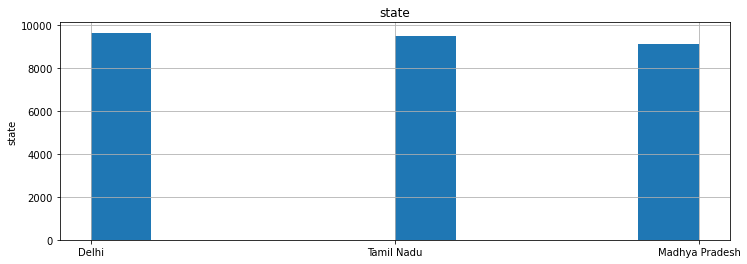

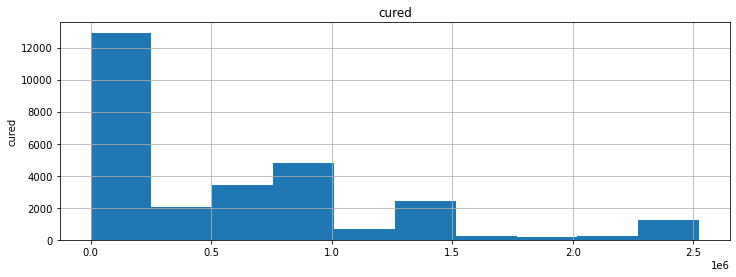

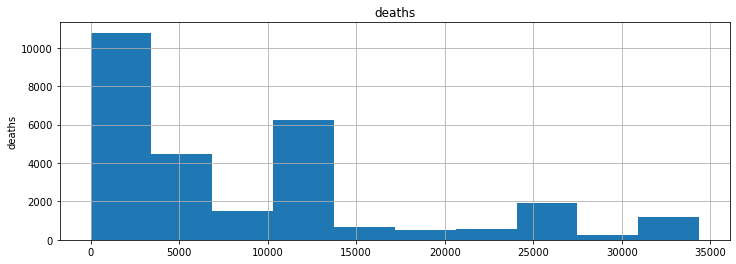

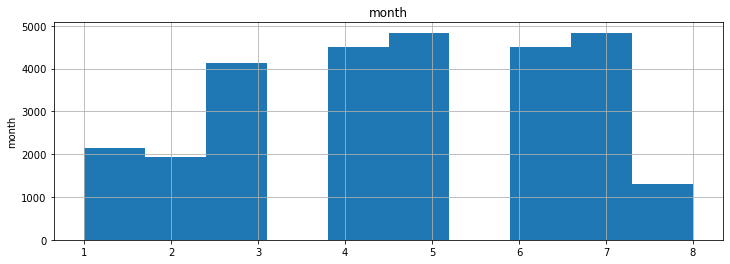

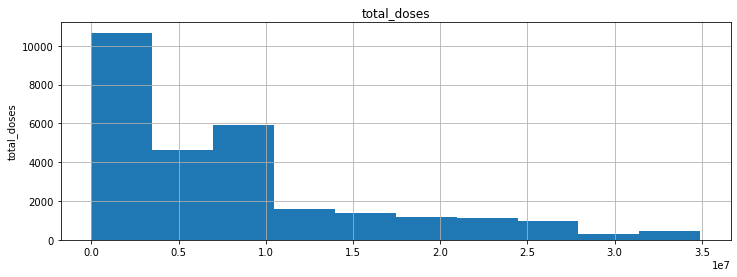

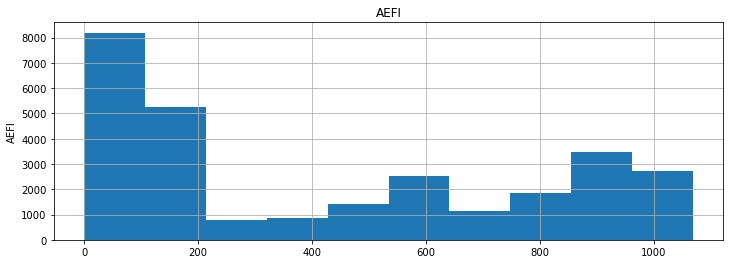

In [49]:
# Take a look at the data
for col in sum_df.columns:
    plt.figure(figsize=(12,4))
    sum_df[col].hist()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

### Takeawys for Prepare:
- Organized the two dataframes by month and state, and then combined the dataframes
- Huge short-lived spikes when looking at daily periods, observations may have been saved for reporting dates
- Both cured and deaths start out high and then decrease over time
- AEFI starts high, decreases largely, then slightly increases towards the end

# Explore

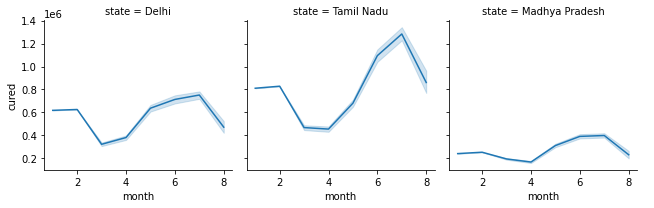

In [62]:
grid = sns.FacetGrid(sum_df, col='state')
grid.map(sns.lineplot, 'month', 'cured')
grid.add_legend()
plt.show()

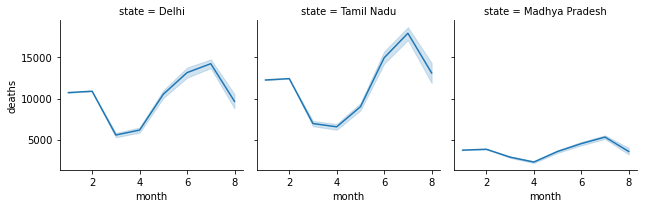

In [63]:
grid = sns.FacetGrid(sum_df, col='state')
grid.map(sns.lineplot, 'month', 'deaths')
grid.add_legend()
plt.show()

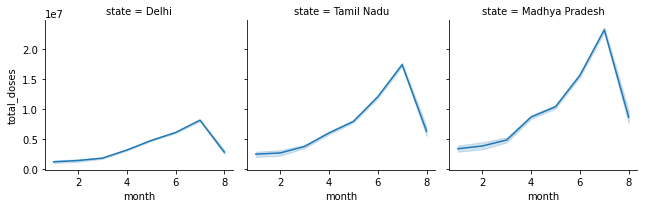

In [64]:
grid = sns.FacetGrid(sum_df, col='state')
grid.map(sns.lineplot, 'month', 'total_doses')
grid.add_legend()
plt.show()

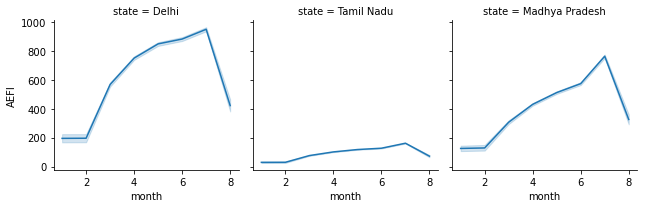

In [65]:
grid = sns.FacetGrid(sum_df, col='state')
grid.map(sns.lineplot, 'month', 'AEFI')
grid.add_legend()
plt.show()

### A cycical pattern can't be seen in this time-frame
### Time-series forecasting should not be used with this dataset

In [69]:
def data_split(df):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=123, 
                                            stratify = df.month)
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=123,
                                       stratify=train_validate.month)
    return train, validate, test

train, validate, test = data_split(sum_df)
train.shape, validate.shape, test.shape

((15780, 6), (6763, 6), (5636, 6))

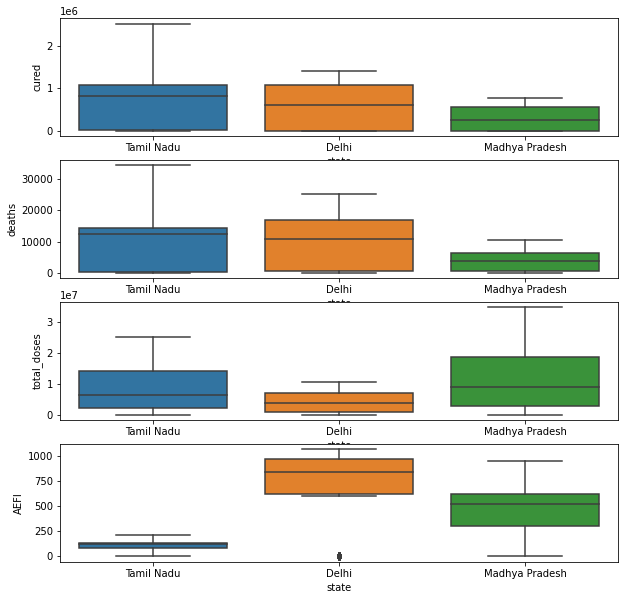

In [98]:
# Take a look at the data

# Increase the size of the figure to prevent overlapping
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1) # <- row, columns, index
sns.boxplot( x = train.state, y = train.cured)

plt.subplot(4, 1, 2)
sns.boxplot( x = train.state, y = train.deaths)

plt.subplot(4, 1, 3)
sns.boxplot( x = train.state, y = train.total_doses)

plt.subplot(4, 1, 4)
sns.boxplot( x = train.state, y = train.AEFI)
plt.show()

In [70]:
# cured has the best correlation with deaths
# Surprisingly, the correlation is positive
# This may be because cured is dependent on the number of people infected
# More infections means more deaths
train.corr()

,cured,deaths,month,total_doses,AEFI
cured,1.0,0.9845086569512865,0.16897272238388622,0.07857073607006605,-0.07126106299930106
deaths,0.9845086569512865,1.0,0.17017724617444277,0.030267976630224087,-0.013484343100420315
month,0.16897272238388622,0.17017724617444277,1.0,0.48653897470606333,0.34115956425636856
total_doses,0.07857073607006605,0.030267976630224087,0.48653897470606333,1.0,0.35574175194961943
AEFI,-0.07126106299930106,-0.013484343100420315,0.34115956425636856,0.35574175194961943,1.0


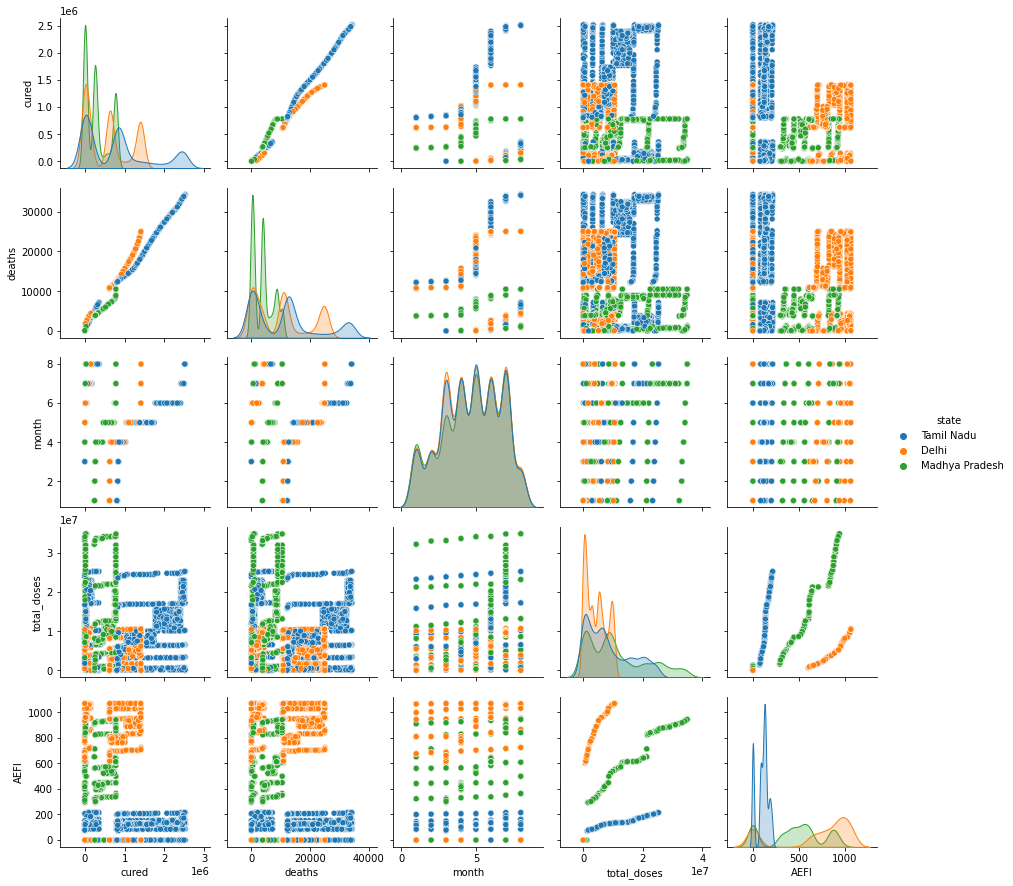

In [100]:
sns.pairplot(train, hue='state')

### Takeaways from Explore
- Although data is time-series, a repeating pattern can't be found within this time-frame
- cured strongly correlates to deaths, because more infected means both more cured and more deaths
- state influences AEFI
- AEFI influences deaths, when also controlled for state